# 특화 모델4(강남구, 마포구, 서초구, 영등포구)

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.utils import resample
import shap

In [ ]:
df = pd.read_csv("data/seoul_preprocessed.csv")
print(df.shape)

(44090, 31)


In [49]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(index=test_df.index)

In [50]:
# test를 제외한 데이터로 risk level 추출
df_nonzero = train_df[train_df['tow_count'] > 0]

# `tow_count` 값으로 정렬
df_nonzero = df_nonzero.sort_values(by='tow_count')

total_nonzero = len(df_nonzero)

mid_end = int(total_nonzero*1/2) # 절반

# 각 구간 끝값 (경계)
mid_end_value = df_nonzero.iloc[mid_end - 1]['tow_count']  # 가운데 구간 끝값

print(f"가운데 구간 끝값: {mid_end_value}\n")


train_df['risk_level'] = train_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)

test_df['risk_level'] = test_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)


# 결과 확인
print(train_df[['tow_count', 'risk_level']].tail())

가운데 구간 끝값: 2

       tow_count  risk_level
44085          0           0
44086          0           0
44087          0           0
44088          0           0
44089          0           0


In [54]:
# 지역 기반 분할
selected_gu = ["강남구", "마포구", "서초구", "영등포구"]
train_df = train_df[train_df["SIG_KOR_NM"].isin(selected_gu)]

In [56]:
features = train_df.columns[3:-2]
target = 'risk_level'
del train_df['tow_count']
del test_df['tow_count']

# 테스트 데이터 준비
train = train_df.iloc[:,3:]
X_test, y_test   = test_df[features], test_df[target]

In [58]:
exp_clf = setup(data = train, target = target, session_id=42)

,Description,Value
0,Session id,42
1,Target,risk_level
2,Target type,Multiclass
3,Original data shape,"(8029, 28)"
4,Transformed data shape,"(8029, 28)"
5,Transformed train set shape,"(5620, 28)"
6,Transformed test set shape,"(2409, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


In [59]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7991,0.0000,0.7991,0.7329,0.7358,0.1213,0.1763,8.1750
dummy,Dummy Classifier,0.7977,0.5000,0.7977,0.6363,0.7079,0.0000,0.0000,0.0190
ridge,Ridge Classifier,0.7975,0.0000,0.7975,0.6546,0.7085,0.0022,0.0128,0.0670
rf,Random Forest Classifier,0.7966,0.8084,0.7966,0.7150,0.7305,0.1044,0.1529,0.5820
ada,Ada Boost Classifier,0.7932,0.0000,0.7932,0.7125,0.7284,0.0968,0.1394,0.6650
lr,Logistic Regression,0.7922,0.0000,0.7922,0.6838,0.7122,0.0272,0.0580,3.7510
lda,Linear Discriminant Analysis,0.7920,0.0000,0.7920,0.6794,0.7159,0.0439,0.0792,0.0520
lightgbm,Light Gradient Boosting Machine,0.7900,0.8265,0.7900,0.7221,0.7415,0.1639,0.1936,9.0330
et,Extra Trees Classifier,0.7897,0.7934,0.7897,0.7120,0.7324,0.1183,0.1515,0.3740
xgboost,Extreme Gradient Boosting,0.7865,0.8209,0.7865,0.7241,0.7442,0.1803,0.2024,0.9430


In [64]:
xgb = create_model('xgboost', class_weight='balanced')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7758,0.8151,0.7758,0.7165,0.7369,0.1516,0.1668
1,0.8043,0.8263,0.8043,0.7586,0.7687,0.2560,0.2829
2,0.7918,0.8120,0.7918,0.7274,0.7385,0.1306,0.1647
3,0.7865,0.8163,0.7865,0.7296,0.7511,0.2227,0.2391
4,0.8007,0.8253,0.8007,0.7433,0.7589,0.2333,0.2639
5,0.7776,0.8159,0.7776,0.7175,0.7373,0.1560,0.1736
6,0.7758,0.8158,0.7758,0.6913,0.7245,0.1119,0.1312
7,0.7811,0.8406,0.7811,0.7099,0.7357,0.1574,0.1779
8,0.7794,0.8077,0.7794,0.7171,0.7393,0.1702,0.1877


In [65]:
tuned_xgb = tune_model(xgb, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7633,0.8061,0.7633,0.7139,0.7342,0.1639,0.1716
1,0.7954,0.8055,0.7954,0.7400,0.7560,0.2183,0.2424
2,0.7900,0.7964,0.7900,0.7170,0.7388,0.1461,0.1760
3,0.7865,0.8083,0.7865,0.7369,0.7535,0.2222,0.2385
4,0.8007,0.8118,0.8007,0.7475,0.7613,0.2367,0.2662
5,0.7865,0.7937,0.7865,0.7302,0.7492,0.2045,0.2236
6,0.7900,0.8111,0.7900,0.7210,0.7436,0.1766,0.2045
7,0.8060,0.8557,0.8060,0.7550,0.7682,0.2667,0.2955
8,0.7811,0.7943,0.7811,0.7158,0.7391,0.1691,0.1882


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [66]:
final_model = finalize_model(tuned_xgb)
prediction = predict_model(final_model, data = X_test)

In [67]:
prediction

,isSchool,rental_count,return_count,apart,closest_hospital_dist,closest_convenience_dist,closest_culture_dist,age_20s,age_30s,age_40s,...,subway_avg_alight,area20,area30,area40,wp_area20,wp_area30,wp_area40,isCommercial,prediction_label,prediction_score
38207,0,0.000000,0.000000,0.000000,5.325478,4.627883,6.015660,8.276779,8.681676,8.432479,...,0.0,11.440591,11.843297,11.651719,3.795489,4.430817,4.471639,1,0,0.5952
34015,0,0.000000,0.000000,0.000000,5.086802,3.935616,5.987284,8.486584,8.766016,8.777035,...,0.0,12.414078,12.633709,12.621968,6.658653,6.378850,6.437352,1,0,0.9721
20315,0,3.559028,3.605673,0.000000,3.972599,3.193857,5.530240,7.868601,7.641568,7.488942,...,0.0,12.223945,12.231263,12.244367,3.481240,3.778491,3.921973,1,2,0.4704
32199,0,0.000000,0.000000,0.000000,4.434495,4.113351,6.348045,8.328084,8.386347,8.454794,...,0.0,12.411438,12.528260,12.538799,4.200954,4.943427,5.154736,1,0,0.9415
29840,0,0.000000,0.000000,7.850103,4.027646,4.496809,6.367069,7.717233,8.243472,8.305729,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.9626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41569,0,0.000000,0.000000,0.000000,4.783676,4.556271,6.712779,7.117584,7.240508,7.263411,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0.8404
22776,0,0.000000,0.000000,0.000000,3.764289,3.869840,5.768969,7.857319,7.983320,8.158035,...,0.0,9.822779,10.120211,10.381793,2.505526,2.602690,2.740840,1,0,0.9920
26942,0,0.000000,0.000000,7.126891,5.059654,4.032720,6.501971,8.422400,8.412317,8.552222,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,2,0.6885
31596,0,4.559633,4.548770,5.891644,2.166850,2.288287,5.934356,8.995362,8.950693,8.692975,...,0.0,12.733198,12.722761,12.550138,7.326795,7.761639,7.744245,1,1,0.7487


In [68]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, prediction['prediction_label'], average ="weighted")
print(f"f1_score: {f1:.4f}")

f1_score: 0.7204


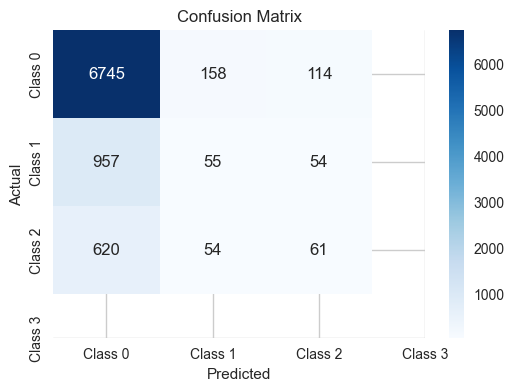

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 계산
cm = confusion_matrix(y_test, prediction['prediction_label'])

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

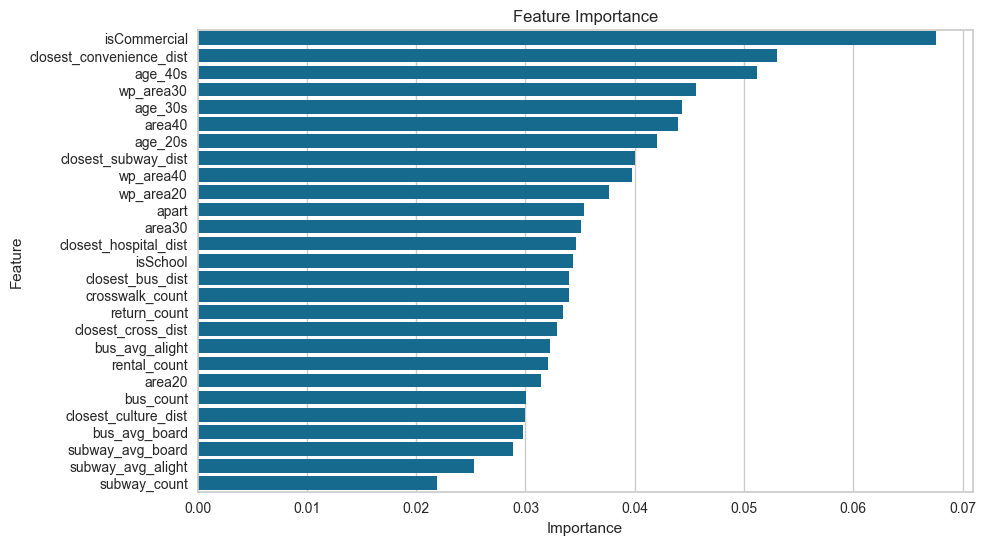

In [70]:
model_feature_importance = final_model.feature_importances_

# 중요도 값과 feature 이름을 함께 출력
features = get_config('X_train').columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': model_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

클래스 0


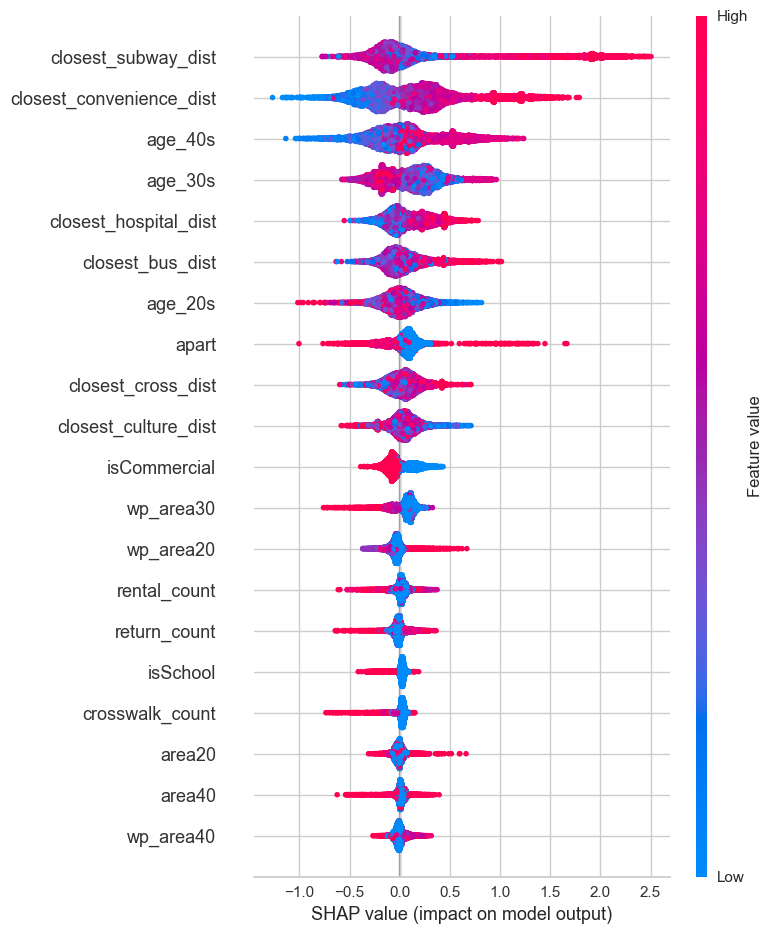

클래스 1


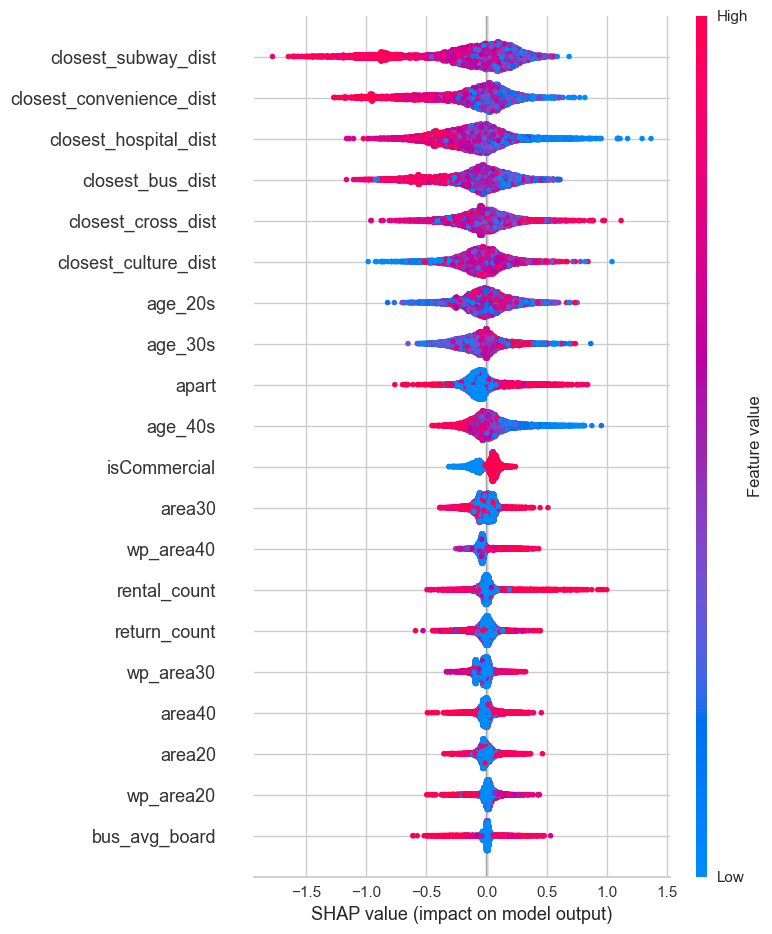

클래스 2


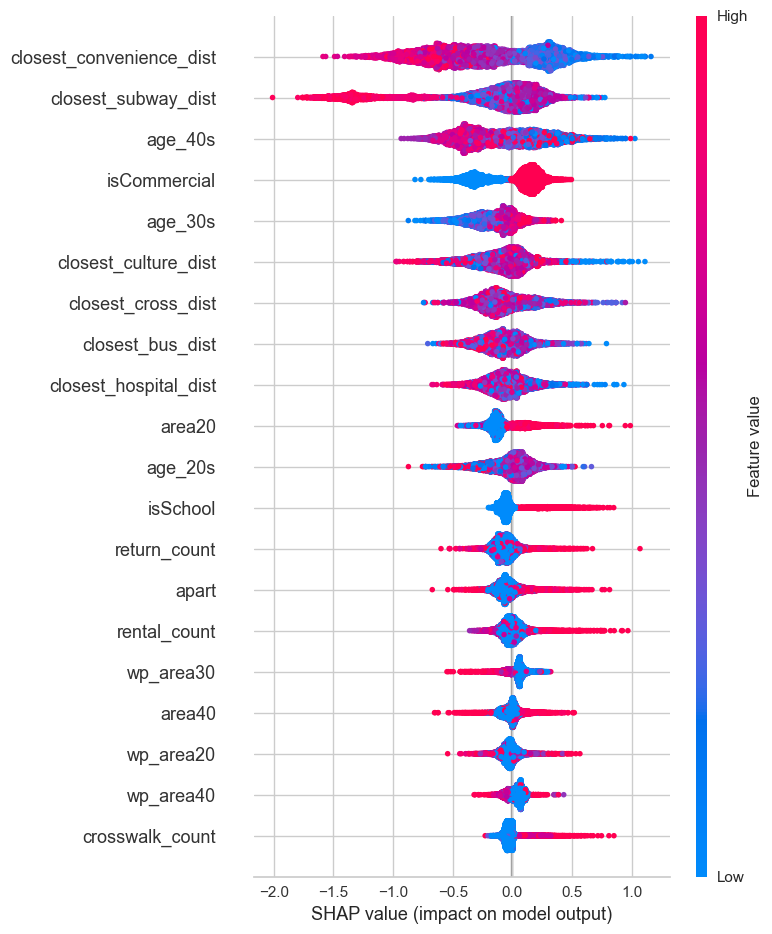

In [72]:
X_test_transformed = final_model[:-1].transform(X_test)

explainer = shap.Explainer(final_model.steps[-1][1])
shap_values = explainer(X_test_transformed)

for class_idx in range(shap_values.values.shape[2]):
    print(f"클래스 {class_idx}")
    plt.figure(figsize=(8, 4))
    shap.summary_plot(shap_values.values[:, :, class_idx], X_test_transformed)

In [ ]:
# 모델 저장
save_model(final_model, 'models/domain_specific_model_4')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['isSchool', 'rental_count',
                                              'return_count', 'apart',
                                              'closest_hospital_dist',
                                              'closest_convenience_dist',
                                              'closest_culture_dist', 'age_20s',
                                              'age_30s', 'age_40s',
                                              'crosswalk_count',
                                              'closest_cross_dist', 'bus_count',
                                              'closest_bus_dist', 'subway_count',
                                              'clos...
                                feature_types=None, feature_weights=None,
                                gamma=None, grow_policy=None,
            